# Developing a Model to Detect Offsides in a Football Match

Is it possible to teach a computer the most complex rule of football, the offside, by using very simple models and data from a single game?

## 1. The Offside 

A player is in an "offside position" if they are in the opposing team's half of the field and also "nearer to the opponents' goal line than both the ball and the second-last opponent." This is a brief description, and we can develop it a little further by stating the five conditions that must be met.<br>
1. A teammate touches the ball, either by a pass, a headbutt or kicking towards the goal;
2. The pass is not from a corner kick, a goal kick or a throw-in;
3. The receiving player is in the offensive half of the field;
4. The receiving player is closer to the goal line than the ball;
5. There is only one player from the other team between the receiving player and the goal line.

When all five conditions happen in a given play, the game must be stopped and a free kick is given to the defensive team.

### 1.1 Learning by Example

Our goal here is to create a model where these rules are not explicitly written, but are learned from a data set of annotated plays. That is, we are going to feed the model with a series of plays, with the position of the 22 players, 11 for each team, the player who is passing the ball and the receiver, with a label "offside" or "no_offside". We will evaluate the model afterwards to see how good is the fit.

# 2. Data set

We found some collections of data with offsides, but they didn't include the position of the players. Furthermore, we also needed data for the cases where no offside happened. There were two possible paths:
1. create a large number of plays by choosing randomly the position for all the players;
2. find real data from, at least, one football match.

### 2.1 Random positions

Pros: very easy to create a large number of plays.<br>
Cons: most of the plays are unrealistic for a football match.

**Conclusion:** too much junk.

### 2.2 Real data

Pros: real situations from a football match.<br>
Cons: very hard data to find; data cleaning necessary; possible need for data augmentation. 

**Jackpot:** we found **ONE** match!

We have found a data set called <a href="https://old.datahub.io/dataset/magglingen2013">Magglingen2013</a>.<br> 
*Recorded position data of professional football matches. The data includes positions on football field in 100ms steps (10Hz) of the players, and the ball.*<br>
*The games were performed in real competition situation by top swiss football club players (U19). The data was intentionally anonymized, not at last because of the high density of information available.*<br>
*This dataset gives you a glimpse on a possible data stream originating from a live match in some not to distant future.*<br>
*The terrain was an artificial green. Recordings are available from beginning of the first half time up to the end to the second half time.*

There are two matches listed at this website, but the links are broken. We were able to find the file for "*Game TR vs. FT*", so we are using that as our initial data set. The file is a JSON file, with a timestamp and, for each player, an identifier, the coordinates on the field (x,y), the distance to the ball and if he has the possession of the ball.

<img src="json.png"></img>

There is a second JSON file, matching the player ID with one of the two teams, and another ID for the ball itself.

<img src="json2.png"></img>

## 3. Data Exploration and Data Cleaning

Let's understand a little better the data before we try any cleaning. For example, we need to find out the size of the field to be able to find anomalies.

In [1]:
import json
print('Loading data')

#reading game data
print('Reading game data')
filename='tr-ft.json'
with open(filename) as json_file:
    data_game = json.load(json_file)

#reading team players
print('Reading team data')
filename2='tr-ft-gamedesc.json'    
with open(filename2) as json_file:
    data_teams = json.load(json_file)

data_teams

Loading data
Reading game data
Reading team data


{'teams': {'0': {'name': 'ball', 'color': 'white'},
  '1': {'name': 'FC TR', 'color': 'red'},
  '2': {'name': 'FC FT', 'color': 'blue'}},
 'player': {'5': {'team': 0},
  '15': {'team': 1},
  '16': {'team': 1},
  '19': {'team': 1},
  '30': {'team': 1},
  '25': {'team': 1},
  '29': {'team': 1},
  '20': {'team': 1},
  '22': {'team': 1},
  '11': {'team': 1},
  '12': {'team': 1},
  '23': {'team': 1},
  '72': {'team': 2},
  '41': {'team': 2},
  '45': {'team': 2},
  '65': {'team': 2},
  '43': {'team': 2},
  '61': {'team': 2},
  '47': {'team': 2},
  '46': {'team': 2},
  '60': {'team': 2},
  '64': {'team': 2},
  '73': {'team': 2}}}

We need the IDs for each player. In the next step, we will create a list with the teams, first the eleven player from *Team 1*, then eleven players from *Team 2*.

In [2]:
#list of players, 11 for team 1, 11 for team 2
lineup=[]
for i in data_teams['player'].keys():
    teams=[i,data_teams['player'][i]['team']]
    
    lineup.append(teams)

lineup

[['5', 0],
 ['15', 1],
 ['16', 1],
 ['19', 1],
 ['30', 1],
 ['25', 1],
 ['29', 1],
 ['20', 1],
 ['22', 1],
 ['11', 1],
 ['12', 1],
 ['23', 1],
 ['72', 2],
 ['41', 2],
 ['45', 2],
 ['65', 2],
 ['43', 2],
 ['61', 2],
 ['47', 2],
 ['46', 2],
 ['60', 2],
 ['64', 2],
 ['73', 2]]

The ID **5** is the ball. The IDs are ordered by team, so we don't need the second column.

In [3]:
lineup = [ item for elem in lineup for item in elem]
lineup = lineup[::2]
lineup

['5',
 '15',
 '16',
 '19',
 '30',
 '25',
 '29',
 '20',
 '22',
 '11',
 '12',
 '23',
 '72',
 '41',
 '45',
 '65',
 '43',
 '61',
 '47',
 '46',
 '60',
 '64',
 '73']

Now that we processed the team data, let's take a look at the game data. As we have showed before, for each instant we have the position of the ball and of the 22 players. 

In [4]:
data_game[0]

{'game': 'NN7SxDe8uLmvKLiQd',
 'ts': 3232387,
 'data': [{'id': 5, 'x': -1.108, 'y': 0.155, 'distToBall': 0, 'poss': False},
  {'id': 11,
   'x': -0.27,
   'y': -0.63,
   'distToBall': 1.1482460537707064,
   'poss': False},
  {'id': 12,
   'x': -0.408,
   'y': -29.365,
   'distToBall': 29.52829829163882,
   'poss': False},
  {'id': 15,
   'x': -45.583,
   'y': -0.254,
   'distToBall': 44.47688057856576,
   'poss': False},
  {'id': 16,
   'x': -15.173,
   'y': 7.564,
   'distToBall': 15.89709111755984,
   'poss': False},
  {'id': 19,
   'x': -15.845,
   'y': -4.697,
   'distToBall': 15.515188461633329,
   'poss': False},
  {'id': 20,
   'x': -1.026,
   'y': 29.019,
   'distToBall': 28.86411647703771,
   'poss': False},
  {'id': 22,
   'x': -0.014,
   'y': 27.519,
   'distToBall': 27.385860074133145,
   'poss': False},
  {'id': 23,
   'x': -0.053,
   'y': 0.547,
   'distToBall': 1.125472789542244,
   'poss': False},
  {'id': 25,
   'x': -9.062,
   'y': -16.995,
   'distToBall': 18.9047247

We are going to create a DataFrame where the first column is the timestamp and then the position for the ball and each one of the players, in the order of the lineup.

In [5]:
import numpy as np
events = []
for ii in range(len(data_game)):
    new_play = [data_game[ii]['ts']]
    positions = []
    for jj in range(len(data_game[ii]['data'])):
        position_player = [data_game[ii]['data'][jj]['id']]
        position_player.append(data_game[ii]['data'][jj]['x'])
        position_player.append(data_game[ii]['data'][jj]['y'])
        positions.append(position_player)
    
    for kk in lineup:
        temp_x = np.nan
        temp_y = np.nan    
        for ll in range(len(positions)):
            if int(kk) == positions[ll][0]:
                temp_x = positions[ll][1]
                temp_y = positions[ll][2]
        new_play.append(temp_x)
        new_play.append(temp_y)

    events.append(new_play)

print('Number of frames of the game: ',len(events))

Number of frames of the game:  68031


In [6]:
columns_events=['timestamp']
for ii in range(len(lineup)):
    columns_events.append('x_'+lineup[ii])
    columns_events.append('y_'+lineup[ii])

In [7]:
import pandas as pd
df_events = pd.DataFrame(events, columns=columns_events)
df_events.head()

,timestamp,x_5,y_5,x_15,y_15,x_16,y_16,x_19,y_19,x_30,...,x_47,y_47,x_46,y_46,x_60,y_60,x_64,y_64,x_73,y_73
0,3232387,-1.108,0.155,-45.583,-0.254,-15.173,7.564,-15.845,-4.697,-11.883,...,14.344,6.372,14.353,-2.178,9.481,0.167,3.442,-13.896,-0.249,8.613
1,3232487,-1.159,0.102,-45.490,-0.248,-15.183,7.560,-15.820,-4.714,-11.813,...,14.344,6.369,14.351,-2.193,9.483,0.174,3.437,-13.939,-0.250,8.608
2,3232587,-1.203,0.068,-45.395,-0.247,-15.195,7.555,-15.795,-4.731,-11.736,...,14.347,6.362,14.341,-2.221,9.482,0.174,3.432,-13.983,-0.258,8.582
3,3232687,-1.226,0.054,-45.299,-0.251,-15.208,7.550,-15.770,-4.749,-11.653,...,14.352,6.354,14.324,-2.264,9.476,0.165,3.427,-14.030,-0.277,8.526
4,3232787,-1.251,0.039,-45.201,-0.262,-15.222,7.546,-15.744,-4.768,-11.562,...,14.356,6.347,14.299,-2.317,9.465,0.147,3.423,-14.079,-0.307,8.435


We have a DataFrame where each row is the configuration of players in the field at a given instant. Our data fas a 10Hz frequency, that is, we have 10 row for each second. We can see there is very little variation from one row to the next. <br>
Let's have a quick look at some statistics.

In [8]:
df_events.describe()

,timestamp,x_5,y_5,x_15,y_15,x_16,y_16,x_19,y_19,x_30,...,x_47,y_47,x_46,y_46,x_60,y_60,x_64,y_64,x_73,y_73
count,6.803100e+04,68031.000000,68031.000000,68031.000000,68031.000000,68031.000000,68031.000000,68031.000000,68031.000000,68031.000000,...,68031.000000,68031.000000,68031.000000,68031.000000,68031.000000,68031.000000,68031.000000,68031.000000,68031.000000,68031.000000
mean,6.633887e+06,28105.748236,28107.049965,7839.032658,7834.289653,33443.170354,33439.285577,8206.315369,8196.519593,9074.940413,...,8713.498574,8702.816891,8409.042070,8400.319571,14595.566937,14582.718796,14686.085871,14680.140936,8057.364362,8049.045565
std,1.963900e+06,44955.771238,44954.955654,26878.782295,26880.146881,47179.926058,47182.680263,27438.704115,27441.629304,28718.367599,...,28195.985494,28199.285582,27745.250611,27747.894737,35301.217502,35306.530129,35392.641515,35395.111126,27214.069176,27216.530197
min,3.232387e+06,-51.947000,-33.987000,-93.648000,-186.237000,-48.863000,-218.195000,-52.382000,-335.400000,-49.743000,...,-50.121000,-196.076000,-46.246000,-183.160000,-52.768000,-296.434000,-52.371000,-444.033000,-53.089000,-202.441000
25%,4.933137e+06,-13.390500,-11.884500,-35.238500,-4.387000,-13.594500,-5.200500,-13.634000,-11.244500,-10.569000,...,-7.294500,-13.958000,-8.040500,-9.429500,-7.376000,-17.857000,-9.000000,-14.038000,-15.266000,-13.322500
50%,6.633887e+06,7.525000,6.601000,22.929000,-0.677000,16.346000,9.329000,6.946000,-1.498000,5.691000,...,4.393000,-2.843000,4.325000,-0.375000,9.360000,-2.665000,2.669000,3.463000,2.274000,-1.478000
75%,8.334637e+06,99999.999000,99999.999000,44.030000,3.515000,99999.999000,99999.999000,31.396000,8.614500,28.422500,...,22.771500,9.512000,19.122500,9.051000,28.841500,13.734000,32.851500,34.032000,27.967500,9.302000
max,1.003539e+07,99999.999000,99999.999000,99999.999000,99999.999000,99999.999000,99999.999000,99999.999000,99999.999000,99999.999000,...,99999.999000,99999.999000,99999.999000,99999.999000,99999.999000,99999.999000,99999.999000,99999.999000,99999.999000,99999.999000


We need to get rid of those '99999.999' values and replace them with NaN. 

In [9]:
df_events = df_events.replace([99999.999],np.nan)
df_events.describe()

,timestamp,x_5,y_5,x_15,y_15,x_16,y_16,x_19,y_19,x_30,...,x_47,y_47,x_46,y_46,x_60,y_60,x_64,y_64,x_73,y_73
count,6.803100e+04,48908.000000,48908.000000,62698.000000,62698.000000,45279.000000,45279.000000,62451.000000,62451.000000,61860.000000,...,62106.000000,62106.000000,62313.000000,62313.000000,58104.000000,58104.000000,58042.000000,58042.000000,62551.000000,62551.000000
mean,6.633887e+06,-4.862653,-3.051948,-0.044083,-5.190521,-0.610767,-6.447584,4.545107,-6.125923,4.482338,...,4.637674,-7.063056,4.421979,-5.100919,4.320257,-10.722973,3.602872,-3.365184,2.407002,-6.640592
std,1.963900e+06,22.124267,16.983440,39.395238,21.459655,32.291269,33.192745,27.851261,24.501821,25.311460,...,22.875914,23.932265,21.395226,23.882738,24.282081,27.411074,26.108486,30.969688,27.059741,25.650617
min,3.232387e+06,-51.947000,-33.987000,-93.648000,-186.237000,-48.863000,-218.195000,-52.382000,-335.400000,-49.743000,...,-50.121000,-196.076000,-46.246000,-183.160000,-52.768000,-296.434000,-52.371000,-444.033000,-53.089000,-202.441000
25%,4.933137e+06,-21.096000,-16.241500,-36.974750,-4.847000,-25.296000,-10.986000,-15.976500,-12.434500,-12.529000,...,-8.712750,-15.497500,-9.172000,-10.221000,-10.970250,-20.838500,-12.501500,-16.348000,-16.731500,-14.877000
50%,6.633887e+06,-2.903000,-4.370500,-18.712000,-1.140000,-5.941000,0.769000,3.681000,-2.693000,3.388500,...,2.550000,-4.719000,2.255000,-1.513000,5.137500,-5.831000,1.802000,-2.340000,-0.026000,-2.722000
75%,8.334637e+06,9.967250,9.527500,37.877750,2.219000,15.995500,9.250000,24.778500,5.789500,18.940250,...,15.751000,6.101000,15.047000,5.838000,14.181000,5.176250,15.947250,14.858500,17.696500,5.593000
max,1.003539e+07,51.948000,33.977000,104.935000,32.293000,118.159000,34.805000,177.522000,34.798000,104.147000,...,110.317000,34.601000,109.202000,30.879000,149.304000,33.411000,293.684000,49.655000,111.663000,34.054000


After this first clean up, we can see the columns x_5 and y_5 had a huge drop in the count, at 48908 from the original 68031. That means we don't have the location of the ball for 31 minutes and 52.3 seconds, but the data is available for 81 minutes and 30.8 seconds, consistent with a match duration of 90 minutes. There must be some events where the ball is out of bounds that add up to the missing time. <br>
The position of the players also have a drop in the count, what probably must be related to the half time break. <br>
Let's take a look at the distribution of (X,Y) for all the players. We will create histograms to try to determine the length and width of the field. 

In [10]:
list_of_x = []
list_of_y = []
for column in columns_events:
    if column[:2] == 'x_':
        list_of_x.append(df_events[column].tolist())
    elif column[:2] == 'y_':
        list_of_y.append(df_events[column].tolist())

list_of_x = [ item for elem in list_of_x for item in elem]
list_of_y = [ item for elem in list_of_y for item in elem]
print('X: ',list_of_x[:10])
print('Y: ',list_of_y[:10])


X:  [-1.108, -1.159, -1.203, -1.226, -1.251, -1.275, -1.304, -1.339, -1.384, -1.441]
Y:  [0.155, 0.102, 0.068, 0.054, 0.039, 0.025, 0.009, -0.01, -0.031, -0.058]


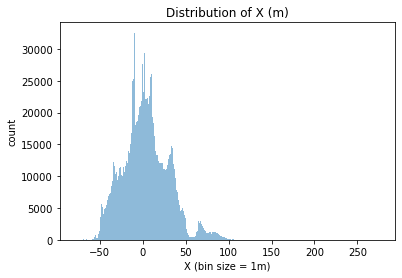

In [11]:
import matplotlib.pyplot as plt

#from the description of the position of the ball
x_min = -52
x_max = 52

# fixed bin size
bins = np.linspace(10*x_min, 10*x_max, 1050) # fixed bin size

plt.xlim([min(list_of_x), max(list_of_x)])
plt.title('Distribution of X (m)')
plt.xlabel('X (bin size = 1m)')
plt.ylabel('count')
plt.hist(list_of_x, bins=bins, alpha=0.5)
plt.show()

We can see we need to clean more of the data. Most of the data is within the range of positions for the ball, (-52,52), which we got from the table describing the columns. Let's take a closer look.

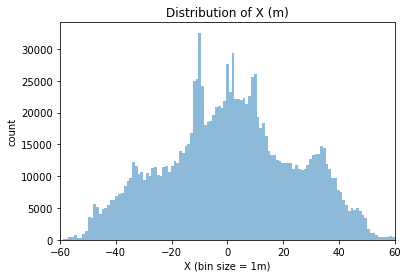

In [12]:
plt.xlim([-60, 60])
plt.title('Distribution of X (m)')
plt.xlabel('X (bin size = 1m)')
plt.ylabel('count')
plt.hist(list_of_x, bins=bins, alpha=0.5)
plt.show()

From this histogram, we learn two things:
1. The X position is in the direction of the length of the field, with the center at 0 and the goal lines at +/- 52m;
2. We need to clean more data, getting rid of all the positions where the players are more than 2 meters off the field (to allow corner kicks and the goalies retrieving the ball).

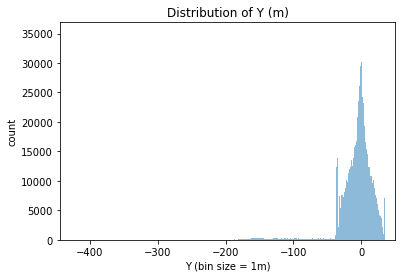

In [13]:
#from the description of the position of the ball
y_min = -34
y_max = 34

# fixed bin size
bins = np.linspace(10*y_min, 10*y_max, 1050) # fixed bin size

plt.xlim([min(list_of_y), max(list_of_y)])
plt.title('Distribution of Y (m)')
plt.xlabel('Y (bin size = 1m)')
plt.ylabel('count')
plt.hist(list_of_y, bins=bins, alpha=0.5)
plt.show()

We can see we need to clean more of the data. Most of the data is within the range of positions for the ball, (-34,34), which we got from the table describing the columns. Let's take a closer look.

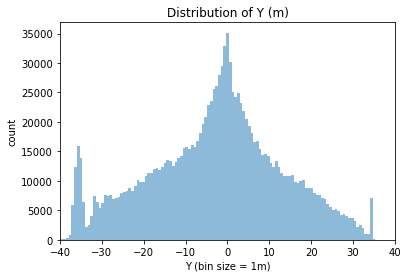

In [14]:
plt.xlim([-40, 40])
plt.title('Distribution of Y (m)')
plt.xlabel('Y (bin size = 1m)')
plt.ylabel('count')
plt.hist(list_of_y, bins=bins, alpha=0.5)
plt.show()

From this histogram, we learn two things:
1. The Y position is in the direction of the width of the field, with the center at 0 and the side lines at +/- 34m;
2. We need to clean more data, getting rid of all the positions where the players are more than 2 meters off the field (to allow the throw-ins).

We are replacing every X over +/- 54 and every Y over +/- 36 with NaN.

In [15]:
for column in columns_events:
    if column[:2] == 'x_':
        df_events[column].loc[df_events[column] < -54] = np.nan
        df_events[column].loc[df_events[column] > 54] = np.nan
    if column[:2] == 'y_':
        df_events[column].loc[df_events[column] < -36] = np.nan
        df_events[column].loc[df_events[column] > 36] = np.nan


/home/rodrigolink/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/rodrigolink/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/rodrigolink/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [16]:
df_events.describe()

,timestamp,x_5,y_5,x_15,y_15,x_16,y_16,x_19,y_19,x_30,...,x_47,y_47,x_46,y_46,x_60,y_60,x_64,y_64,x_73,y_73
count,6.803100e+04,48908.000000,48908.000000,60612.000000,60037.000000,41801.000000,41915.000000,60107.000000,60020.000000,59649.000000,...,59937.000000,60132.000000,60035.000000,60233.000000,55658.000000,48655.000000,55589.000000,55649.000000,60049.000000,60255.000000
mean,6.633887e+06,-4.862653,-3.051948,-0.164862,-1.542613,-6.883045,1.415731,1.806833,-2.352721,1.921631,...,2.130713,-3.807451,1.753267,-1.518526,1.271545,-2.435155,0.414721,1.075533,-0.576834,-2.751578
std,1.963900e+06,22.124267,16.983440,38.058993,7.814246,24.642348,14.276002,24.454256,12.443707,21.850645,...,18.936913,14.247606,16.617729,12.063243,19.736186,14.617752,21.269728,19.959168,23.147244,14.295807
min,3.232387e+06,-51.947000,-33.987000,-53.991000,-36.000000,-48.863000,-36.000000,-52.382000,-36.000000,-49.743000,...,-50.121000,-35.939000,-46.246000,-35.948000,-52.768000,-36.000000,-52.371000,-35.912000,-53.089000,-36.000000
25%,4.933137e+06,-21.096000,-16.241500,-36.285250,-4.145000,-26.121000,-8.105500,-17.076500,-10.826250,-13.140000,...,-9.241000,-13.959000,-9.670500,-9.355000,-11.761250,-12.193000,-13.318000,-14.641000,-17.603000,-12.858500
50%,6.633887e+06,-2.903000,-4.370500,-18.633000,-0.906000,-8.057000,2.220000,2.145000,-2.156500,2.553000,...,1.992000,-4.101000,1.358000,-1.087000,3.604500,-2.795000,1.760000,-1.213000,-0.775000,-2.233000
75%,8.334637e+06,9.967250,9.527500,37.261250,2.374000,4.777000,10.352000,21.330500,6.261750,16.019000,...,13.551000,6.482000,13.700000,6.203000,11.392750,7.641000,13.126000,15.719000,14.345000,6.122500
max,1.003539e+07,51.948000,33.977000,53.902000,32.293000,53.970000,34.805000,53.991000,34.798000,53.904000,...,53.953000,34.601000,53.987000,30.879000,53.869000,33.411000,53.984000,35.991000,53.990000,34.054000


Now we have all the (x,y) inside the field plus a 2m margin. But we have a new problem: we have a different number of values for x and y for a single player, and different numbers for each player.

In [17]:
for column in columns_events:
    print(column,': ',df_events[column].count())

timestamp :  68031
x_5 :  48908
y_5 :  48908
x_15 :  60612
y_15 :  60037
x_16 :  41801
y_16 :  41915
x_19 :  60107
y_19 :  60020
x_30 :  59649
y_30 :  59896
x_25 :  60160
y_25 :  60093
x_29 :  59646
y_29 :  59551
x_20 :  60019
y_20 :  59866
x_22 :  60144
y_22 :  59009
x_11 :  60196
y_11 :  59911
x_12 :  60056
y_12 :  54821
x_23 :  60142
y_23 :  60282
x_72 :  61028
y_72 :  60789
x_41 :  59802
y_41 :  60003
x_45 :  59838
y_45 :  59980
x_65 :  55626
y_65 :  55792
x_43 :  59917
y_43 :  60083
x_61 :  55885
y_61 :  56038
x_47 :  59937
y_47 :  60132
x_46 :  60035
y_46 :  60233
x_60 :  55658
y_60 :  48655
x_64 :  55589
y_64 :  55649
x_73 :  60049
y_73 :  60255


The lower count is for player 16, with around 42.000 rows. He was probably sent off at the start of the second half or was injured.<br>
We have two options:
1. Fill in the gaps in the data, with an average position or a new random location;
2. Remove all the rows with missing data.

Let's take a look at the distribution of these gaps during the game. The ball gets out of the field regularly, so we won't use its position in our analysis.

In [18]:
nans=[]
number_frames_nan=0
sequence_of_nans=0
df_nans=df_events.drop(['x_5', 'y_5'], axis=1).isna()
for ii in range(len(df_events)):
    count_nan=df_nans.loc[[ii]].sum().sum()
    if count_nan>0:
        number_frames_nan += 1
        sequence_of_nans += 1
        if sequence_of_nans > 40:
            sequence_of_nans = 40
    else:
        sequence_of_nans = 0
    nans.append(sequence_of_nans)
print('Number of frames with NaN: ',number_frames_nan)

Number of frames with NaN:  27505


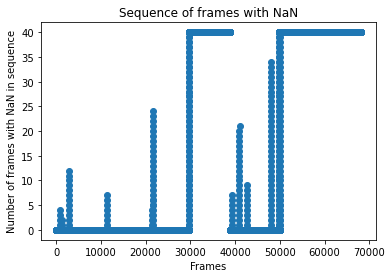

In [19]:
plt.title('Sequence of frames with NaN')
plt.xlabel('Frames')
plt.ylabel('Number of frames with NaN in sequence')
plt.scatter(range(len(df_events)),nans)

How to read the above plot: most of the time we have full data. In the first half, there is an event with 4 rows in a sequence with at least one NaN, another sequence with 12 rows, another with 7 rows, and one with 24 rows. Then we see the end of the first half and the return of the game. We see four sequences (with 6, 20, 8 and 35). After these events, we see what was expected: one player is out for the remainder of the game. 

We have three different groups:
1. Half-time
2. One player out
3. Problematic data

It is important here to remember that the data has a frequency of 10Hz. A sequence of 35 rows, our largest sequence, is equivalent to 3.5 seconds of the game. 

**To keep things simple, we can get rid of all the time frames with incomplete data without compromising our analysis.**

Before we do that, let's make a transformation that will simplify our work later on. The teams trade sides for the second half. We will flip the data for the second half, multiplying them by *-1*, so that the team's offensive half is always the same, *team 1* attacking to the right and *team 2* to the left.

In [20]:
for ii in range(int(len(df_events)/2),len(df_events)):
    df_events.loc[ii]=-1*df_events.loc[ii]

From the original 68031 frames, we have 27505 incomplete rows. This leaves information for 40526 frames, equivalent to 67 minutes and 32 seconds, about 75% of a match. Good enough for us!

In [21]:
df_events_clean=df_events.dropna(subset=columns_events[3:]).reset_index(drop=True)
df_events_clean.describe()

,timestamp,x_5,y_5,x_15,y_15,x_16,y_16,x_19,y_19,x_30,...,x_47,y_47,x_46,y_46,x_60,y_60,x_64,y_64,x_73,y_73
count,4.052600e+04,28706.000000,28706.000000,40526.000000,40526.000000,40526.000000,40526.000000,40526.000000,40526.000000,40526.000000,...,40526.000000,40526.000000,40526.000000,40526.000000,40526.000000,40526.000000,40526.000000,40526.000000,40526.000000,40526.000000
mean,1.372801e+06,-2.903897,-0.734086,-36.714714,-0.576462,-18.263819,6.836821,-19.230786,-6.035919,-11.977085,...,-0.912141,3.550922,4.513465,-2.885631,-8.710720,-0.374610,-9.923223,-12.230482,-16.042204,-0.692408
std,5.545182e+06,22.543002,18.395568,9.440068,6.518123,17.519271,12.037898,15.033612,11.369410,17.729653,...,19.949163,14.256551,16.509935,11.679983,18.745885,14.433891,20.025491,11.632417,17.539447,14.732093
min,-8.227387e+06,-51.947000,-33.987000,-53.902000,-34.729000,-53.912000,-31.941000,-52.382000,-33.827000,-51.804000,...,-52.930000,-34.399000,-33.161000,-33.284000,-52.768000,-34.567000,-52.392000,-35.322000,-53.089000,-35.565000
25%,-7.191962e+06,-18.922500,-16.257000,-46.266750,-3.711750,-32.652750,-2.908750,-32.360750,-14.762000,-26.381000,...,-12.466750,-5.960250,-8.521000,-10.485750,-22.962000,-10.842250,-24.503500,-21.186750,-30.702750,-10.379500
50%,4.166137e+06,-1.386500,-1.442000,-36.443000,-0.536500,-17.965000,5.597000,-18.579000,-5.744500,-10.462500,...,1.189500,4.553500,4.260000,-2.334500,-7.744000,-0.383500,-9.727000,-12.265500,-15.837000,-0.407000
75%,5.179962e+06,12.229500,13.528500,-28.506000,2.950750,-5.199500,16.017000,-6.776500,2.305500,1.654750,...,11.504000,14.236000,16.136000,5.161500,4.989750,9.859000,3.126500,-4.953500,-3.539000,8.435750
max,6.203387e+06,51.814000,33.984000,-15.340000,31.377000,43.462000,36.000000,34.658000,29.476000,44.974000,...,50.121000,35.117000,47.548000,27.569000,35.110000,33.411000,46.362000,33.603000,43.036000,34.054000


We finally have a clean data set to start our project, with 40526 frames with the position of 22 players in real game situations. Let's create a function to show a random row.

In [22]:
df_events_clean.to_csv('df_clean.csv',index=False)

In [22]:
import math
# Create field
fieldx=[]
fieldy=[]
for i in range(-5200,5200,10):
    fieldx.append(i)
    fieldy.append(-3400)
    fieldx.append(i)
    fieldy.append(3400)

for i in range(-3400,3400,10):
    fieldx.append(-5200)
    fieldy.append(i)
    fieldx.append(5200)
    fieldy.append(i)
    fieldx.append(0)
    fieldy.append(i)

for i in range(360):
    fieldx.append(915*math.cos(math.radians(i)))
    fieldy.append(915*math.sin(math.radians(i)))

for i in range(0,2016,10):
    fieldx.append(5200-1650)
    fieldy.append(i)
    fieldx.append(5200-1650)
    fieldy.append(-i)
    fieldx.append(-5200+1650)
    fieldy.append(i)
    fieldx.append(-5200+1650)
    fieldy.append(-i)

for i in range(5200,5200-1650,-10):
    fieldx.append(i)
    fieldy.append(2016)
    fieldx.append(i)
    fieldy.append(-2016)
    fieldx.append(-i)
    fieldy.append(-2016)
    fieldx.append(-i)
    fieldy.append(2016)

for i in range(0,366+550,10):
    fieldx.append(5200-550)
    fieldy.append(i)
    fieldx.append(5200-550)
    fieldy.append(-i)
    fieldx.append(-5200+550)
    fieldy.append(i)
    fieldx.append(-5200+550)
    fieldy.append(-i)

for i in range(5200,5200-550,-10):
    fieldx.append(i)
    fieldy.append(366+550)
    fieldx.append(i)
    fieldy.append(-366-550)
    fieldx.append(-i)
    fieldy.append(-366-550)
    fieldx.append(-i)
    fieldy.append(366+550)

for i in range(360):
    if 5200-1100 + 915*math.cos(math.radians(i))<52-1650:
        fieldx.append(52-11 + 915*math.cos(math.radians(i)))
        fieldy.append(915*math.sin(math.radians(i)))

for i in range(360):
    if -5200+1100 + 915*math.cos(math.radians(i))>-5200+1650:
        fieldx.append(-5200+1100 + 915*math.cos(math.radians(i)))
        fieldy.append(915*math.sin(math.radians(i)))

fieldx.append(5200-1100)
fieldy.append(0)
fieldx.append(-5200+1100)
fieldy.append(0)

def plot_field(index):
    #getting data for the teams
    g1 = (100*df_events_clean.loc[index,'x_5'],100*df_events_clean.loc[index,'y_5'])
    g2 = (100*df_events_clean.loc[index,columns_events[3:25:2]],100*df_events_clean.loc[index,columns_events[4:25:2]])
    g3 = (100*df_events_clean.loc[index,columns_events[25::2]],100*df_events_clean.loc[index,columns_events[26::2]])
    data = (g2,g3,g1)
    colors = ("red", "blue","green")
    groups = ("team1", "team2", "ball")
    size=(30,30,50)

    # Create plot
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    plt.scatter(fieldx,fieldy,s=5,c="black",alpha=0.3)    

    for data, color, group, size in zip(data, colors, groups, size):
        x, y = data
        ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=size, label=group)

    plt.ylim(-3700, 3700)
    plt.xlim(-5500, 5500)
    plt.title('Time frame: '+str(index))
    plt.legend(loc=2)
    plt.show()

    

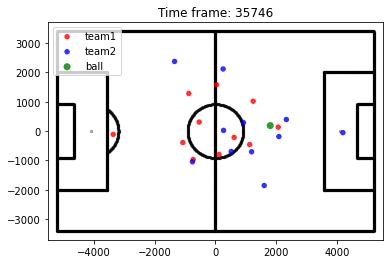

In [23]:
import random
np.random.seed(0)
plot_field(random.randint(0, len(df_events_clean)-1))

There are some frames without the ball, but that is expected. In most of frames we can see clearly the two goalies and that we players gather around the ball. As stated before, *team 1* attacks to the right and *team 2* attacks to the left. With these plots, we can assure our data represents actual game plays and we can move on to data augmentation.

# 4. Data Augmentation

We have more than 40 thousand situations, but let's pump up those numbers! We will create new data by adding noise to the positions of the players. By doing this, we are getting new plays, keeping them similar to real ones. For each row in our data set, we will add a small random contribution for the position of every player. We will get rid of the 'timestamp' column because this won't be used. We can also remove the columns for the ball, as we will use the position of the passing and the receiving plyers on our analysis.

In [24]:
df_plays = df_events_clean.drop(columns=['timestamp','x_5','y_5'])

In [25]:
repetition = 2
df_plays_rep = df_plays.copy()
for ii in range(repetition):
    df_noise = pd.DataFrame(4*np.random.rand(len(df_plays), len(columns_events[3:]))-2, columns =columns_events[3:])
    df_plays_rep=df_plays_rep.append(df_plays.add(df_noise)).reset_index(drop=True)
len(df_plays_rep)

121578

In [26]:
df_plays_rep.loc[0::40526]

,x_15,y_15,x_16,y_16,x_19,y_19,x_30,y_30,x_25,y_25,...,x_47,y_47,x_46,y_46,x_60,y_60,x_64,y_64,x_73,y_73
0,-45.583000,-0.254000,-15.173000,7.564000,-15.845000,-4.697000,-11.883000,1.116000,-9.062000,-16.995000,...,14.344000,6.372000,14.353000,-2.178000,9.481000,0.167000,3.442000,-13.896000,-0.249000,8.613000
40526,-45.387746,0.606757,-14.761946,7.743533,-16.150381,-4.113424,-12.132651,2.683092,-7.207349,-17.461234,...,12.419159,6.842542,14.801383,-1.710264,11.255992,0.894281,2.880032,-14.147872,0.541525,6.853902
81052,-46.699202,1.294616,-15.376622,8.121850,-15.780991,-2.979921,-12.553126,2.491647,-9.002967,-16.841741,...,12.928055,7.391752,13.026040,-3.198717,11.407650,-1.617951,5.067959,-12.549367,-1.847022,8.301126


We have more than 120k plays in our data set. We need now to include three new columns: the passing player, the receiving player and the flag "offside/no_offside". There are 22x22 = 484 possibilities, including the ball coming from the other team and the player keeping the ball. With our 120k plays, we could have a total of 58.843.752 different game situations. This might be a problem, so we are going to randomly select 25 possibilities instead of the 484, leaving us with close to 3 million game situations. For simplicity, the passing and receiving player will be defined by the order of the lineup, that is, these columns will be filled by numbers between 1 and 22.

In [27]:
df_full_plays = df_plays_rep.copy()
df_full_plays['pass'] = 0
df_full_plays['rec'] = 0
df_full_plays['offside'] = 0

df_full = df_full_plays.copy()
for ii in range(24):
    df_full = df_full.append(df_full_plays)
    
passing = []
receiving = []

for ii in range(len(df_full)):
    passing.append(random.randint(1,22))
    receiving.append(random.randint(1,22))

df_full['pass'] = passing
df_full['rec'] = receiving

len(df_full)

3039450

In [28]:
df_full = df_full.reset_index(drop=True)
df_full.head()

,x_15,y_15,x_16,y_16,x_19,y_19,x_30,y_30,x_25,y_25,...,y_46,x_60,y_60,x_64,y_64,x_73,y_73,pass,rec,offside
0,-45.583,-0.254,-15.173,7.564,-15.845,-4.697,-11.883,1.116,-9.062,-16.995,...,-2.178,9.481,0.167,3.442,-13.896,-0.249,8.613,22,6,0
1,-45.490,-0.248,-15.183,7.560,-15.820,-4.714,-11.813,1.115,-9.068,-17.001,...,-2.193,9.483,0.174,3.437,-13.939,-0.250,8.608,16,18,0
2,-45.395,-0.247,-15.195,7.555,-15.795,-4.731,-11.736,1.109,-9.077,-17.007,...,-2.221,9.482,0.174,3.432,-13.983,-0.258,8.582,20,22,0
3,-45.299,-0.251,-15.208,7.550,-15.770,-4.749,-11.653,1.098,-9.089,-17.013,...,-2.264,9.476,0.165,3.427,-14.030,-0.277,8.526,1,17,0
4,-45.201,-0.262,-15.222,7.546,-15.744,-4.768,-11.562,1.080,-9.104,-17.018,...,-2.317,9.465,0.147,3.423,-14.079,-0.307,8.435,10,22,0


We are now ready to annotate the data, determine if the play is an offside or not.

# 5. Data Annotation and Data set Balance

A player is in an "offside position" if they are in the opposing team's half of the field and also "nearer to the opponents' goal line than both the ball and the second-last opponent." This is a brief description, and we can develop it a little further by stating the five conditions that must be met.

1. A teammate touches the ball, either by a pass, a headbutt or kicking towards the goal;
2. The pass is not from a corner kick, a goal kick or a throw-in;
3. The receiving player is in the offensive half of the field;
4. The receiving player is closer to the goal line than the ball;
5. There is only one player from the other team between the receiving player and the goal line.

When all five conditions happen in a given play, the game must be stopped and a free kick is given to the defensive team.
We need to include two new conditions:

6. The receiving player is not the same as the passing one. This means the player can keep the ball to himself even if the above conditions happen.
7. The receiving player must be in the field. The passing player can be outside, when we consider the play a throw-in or a corner kick.

For each game situation previously created, we will evaluate these 7 conditions. The offsides are a small subset of the total plays. Besides checking for offsides, we are creating a number of groups to help creating a more balanced dataset:
1. when all 7 conditions are met, the offsides;
2. when just one of the other conditions is not met, the "close call" non offsides, but excluding condition 5;
3. when the only condition avoiding an offside is the number of players between the receiving player and the goal line, condition 5, the most recurring one;
4. when all 7 conditions aren't met;
5. all the other non offside cases.
 

Let's check how many cases are in each of these groups.

In [29]:
offsides = []
zeroconditions = []
condition1 = []
condition2 = []
condition3 = []
condition4 = []
condition5 = []
condition6 = []
condition7 = []

for ii in range(len(df_full)):
    
    if ii%100000 == 0:
        print('Analysing: ',ii)
    
    offsidemark = []
    
    receiver_team = int(df_full.loc[ii]['rec']/12)
    passer_team = int(df_full.loc[ii]['pass']/12)
    receiver = str(lineup[int(df_full.loc[ii]['rec'])])
    passer = str(lineup[int(df_full.loc[ii]['pass'])])
    
    #condition1: 
    #A teammate touches the ball, either by a pass, a headbutt or kicking towards the goal.
    #check to see if pass and rec are from the same team
    if receiver_team == passer_team:
        offsidemark.append(1)
    else:
        offsidemark.append(0)
    
    #condition2: 
    #The pass is not from a corner kick, a goal kick or a throw-in.
    #check to see if passing player is outside the field
    
    if ((df_full.loc[ii]['x_'+passer] < -52) or (df_full.loc[ii]['x_'+passer] > 52) or (df_full.loc[ii]['y_'+passer] < -34) or (df_full.loc[ii]['y_'+passer] > 34)):
        offsidemark.append(0)
    else:
        offsidemark.append(1)

    #condition3: 
    #The receiving player is in the offensive half of the field.
    #check to see if receiving player is on the offensive half
    
    if (((df_full.loc[ii]['x_'+receiver] > 0) and (receiver_team == 0)) or ((df_full.loc[ii]['x_'+receiver] < 0) and (receiver_team == 1))):
        offsidemark.append(1)
    else:
        offsidemark.append(0)
        
    #condition4: 
    #The receiving player is closer to the goal line than the ball.
    #check to see if receiving player is ahead of the passing player
        
    #team1 attacks to the right
    if ((receiver_team == 0) and (df_full.loc[ii]['x_'+receiver] > df_full.loc[ii]['x_'+passer])):
        offsidemark.append(1)
    #team2 attacks to the left
    elif ((receiver_team == 1) and (df_full.loc[ii]['x_'+receiver] < df_full.loc[ii]['x_'+passer])):
        offsidemark.append(1)
    else:
        offsidemark.append(0)
    
    #condition5: 
    #There is only one player from the other team between the receiving player and the goal line.
    #count how many players from the other team are between receiving playear and the goal line
    
    if (receiver_team == 0):
        count_ahead = 0
        for jj in range(22,2*len(lineup),2):
            if df_full.iloc[ii,jj] > df_full.loc[ii]['x_'+receiver]:
                count_ahead += 1
            
    if (receiver_team == 1):
        count_ahead = 0
        for jj in range(0,22,2):
            if df_full.iloc[ii,jj] < df_full.loc[ii]['x_'+receiver]:
                count_ahead += 1
    
    if count_ahead < 2:
        offsidemark.append(1)
    else:
        offsidemark.append(0)
    
    
    #condition6: 
    #The receiving player is not the same as the passing one
    #check to see receiver == passer
    
    if passer == receiver:
        offsidemark.append(0)
    else:
        offsidemark.append(1)

    #condition7: 
    #The receiving player must be in the field
    #check to see if receiving player is outside the field
    
    if ((df_full.loc[ii]['x_'+receiver] < -52) or (df_full.loc[ii]['x_'+receiver] > 52) or (df_full.loc[ii]['y_'+receiver] < -34) or (df_full.loc[ii]['y_'+receiver] > 34)):
        offsidemark.append(0)
    else:
        offsidemark.append(1)
        

    #now we check all the conditions and group the cases
    
    #when all conditions are met
    if sum(offsidemark) == 7:
        offsides.append(ii)
    
    #when no conditions are met
    if sum(offsidemark) == 0:
        zeroconditions.append(ii)
        
    #when just one of the conditions isn't met
    if sum(offsidemark) == 6:
        if offsidemark[0] == 0:
            condition1.append(ii)
        if offsidemark[1] == 0:
            condition2.append(ii)
        if offsidemark[2] == 0:
            condition3.append(ii)
        if offsidemark[3] == 0:
            condition4.append(ii)
        if offsidemark[4] == 0:
            condition5.append(ii)
        if offsidemark[5] == 0:
            condition6.append(ii)
        if offsidemark[6] == 0:
            condition7.append(ii)  

Analysing:  0
Analysing:  100000
Analysing:  200000
Analysing:  300000
Analysing:  400000
Analysing:  500000
Analysing:  600000
Analysing:  700000
Analysing:  800000
Analysing:  900000
Analysing:  1000000
Analysing:  1100000
Analysing:  1200000
Analysing:  1300000
Analysing:  1400000
Analysing:  1500000
Analysing:  1600000
Analysing:  1700000
Analysing:  1800000
Analysing:  1900000
Analysing:  2000000
Analysing:  2100000
Analysing:  2200000
Analysing:  2300000
Analysing:  2400000
Analysing:  2500000
Analysing:  2600000
Analysing:  2700000
Analysing:  2800000
Analysing:  2900000
Analysing:  3000000


In [30]:
print('Number offsides: ',len(offsides))
print('Number of cases with zero conditions: ',len(zeroconditions))
print('Number of cases without condition 1: ',len(condition1))
print('Number of cases without condition 2: ',len(condition2))
print('Number of cases without condition 3: ',len(condition3))
print('Number of cases without condition 4: ',len(condition4))
print('Number of cases without condition 5: ',len(condition5))
print('Number of cases without condition 6: ',len(condition6))
print('Number of cases without condition 7: ',len(condition7))

Number offsides:  44715
Number of cases with zero conditions:  0
Number of cases without condition 1:  39269
Number of cases without condition 2:  78
Number of cases without condition 3:  133
Number of cases without condition 4:  1000
Number of cases without condition 5:  341528
Number of cases without condition 6:  0
Number of cases without condition 7:  887


From the 3 million plays, close to 45 thousand are offsides. Let's start our final dataset by getting all the cases without one of the conditions, excluding the 5th, and the ones with zero conditions.

In [33]:
final_list = condition1.copy()
if len(condition2)>0:
    final_list.extend(condition2)
if len(condition3)>0:
    final_list.extend(condition3)
if len(condition4)>0:
    final_list.extend(condition4)
if len(condition6)>0:
    final_list.extend(condition6)
if len(condition7)>0:
    final_list.extend(condition7)
if len(zeroconditions)>0:
    final_list.extend(zeroconditions)

len(final_list)

41367

From the 341.528 cases for the condition 5, we will select the same number above. 

In [34]:
final_list.extend(random.sample(condition5,len(final_list)))
len(final_list)

82734

We mapped 427.610 cases on our classification above. That means there are more than 2.5 million other situations. We will pick the same number above.

In [35]:
biglist = set([*range(len(df_full))])
biglist = biglist.difference(offsides)
biglist = biglist.difference(zeroconditions)
biglist = biglist.difference(condition1)
biglist = biglist.difference(condition2)
biglist = biglist.difference(condition3)
biglist = biglist.difference(condition4)
biglist = biglist.difference(condition5)
biglist = biglist.difference(condition6)
biglist = biglist.difference(condition7)

len(biglist)

2611840

In [36]:
final_list.extend(random.sample(biglist,len(final_list)))
len(final_list)

165468

We now have 165.468 plays where there is no offside. We need the same number of offsides, but we only have 44.715. A second round of data augmentation is needed.

# 6. Second Data Augmentation

We need to increase the number of plays with offsides. The solution is quite simple: excluding throw-ins and corner kicks, the conditions are independent of Y. We will generate new plays by altering the position y for the players not involved in the play.

In [37]:
repetition = 3
df_offsides = df_full.loc[offsides].copy()
for ii in range(repetition):
    df_offsides1 = df_full.loc[offsides].copy()
    for jj in range(len(offsides)):
        receiver = str(lineup[int(df_offsides1.iloc[jj]['rec'])])
        passer = str(lineup[int(df_offsides1.iloc[jj]['pass'])])
        for kk in df_offsides1.columns:
            if (kk[:2] == 'y_') and (kk[2:] != receiver) and (kk[:2] != passer):
                df_offsides1.iloc[jj][kk] = df_offsides1.iloc[jj][kk] + 4*np.random.rand() -2
    df_offsides = df_offsides.append(df_offsides1).reset_index(drop=True)

df_offsides['offside']=1
len(df_offsides)        
    
    

<ipython-input-37-b2d76112c8e2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_offsides1.iloc[jj][kk] = df_offsides1.iloc[jj][kk] + 4*np.random.rand() -2


178860

From this group, we will pick the same number of cases we have on our final list.

In [38]:
df_final = df_full.loc[final_list].copy()
sample_offsides = random.sample([*range(len(df_offsides))],len(final_list))
df_final = df_final.append(df_offsides.loc[sample_offsides]).reset_index(drop=True)
len(df_final)

330936

In [39]:
df_final.head()

,x_15,y_15,x_16,y_16,x_19,y_19,x_30,y_30,x_25,y_25,...,y_46,x_60,y_60,x_64,y_64,x_73,y_73,pass,rec,offside
0,-45.530,-0.558,-17.679,-2.416,-25.149,-7.294,-16.921,-5.499,-24.338,-15.504,...,-9.527,-14.075,-3.258,-22.180,-10.128,-24.016,0.063,9,17,0
1,-37.564,-4.213,-18.213,-7.147,-20.275,-22.019,-12.300,-16.257,-12.597,-31.751,...,-24.817,-11.478,-14.808,-11.914,-29.073,-21.167,-7.500,10,22,0
2,-36.370,-4.488,-17.641,-6.419,-20.512,-23.529,-11.594,-15.730,-10.737,-32.420,...,-24.345,-10.410,-15.433,-10.608,-28.882,-20.624,-9.087,11,22,0
3,-24.345,-12.623,-6.533,-12.054,-5.530,-26.960,2.301,-20.626,7.517,-31.575,...,-26.095,5.998,-20.179,13.779,-29.134,-6.763,-23.482,2,22,0
4,-22.101,-13.805,1.591,-10.458,6.288,-21.077,24.058,-16.657,38.884,-29.296,...,-24.531,30.378,-15.241,37.877,-28.028,9.589,-18.132,15,10,0


In [40]:
df_final.tail()

,x_15,y_15,x_16,y_16,x_19,y_19,x_30,y_30,x_25,y_25,...,y_46,x_60,y_60,x_64,y_64,x_73,y_73,pass,rec,offside
330931,-31.352086,1.348684,-0.260896,1.589648,-12.068579,-3.074828,5.924407,-9.613310,-4.886744,-7.662473,...,-4.947448,6.273601,-7.166854,-7.806574,-7.496433,-0.563514,-1.421577,1,9,1
330932,-36.164000,-6.111000,-27.174000,21.242000,-29.563000,-16.306000,-19.895000,6.053000,-3.898000,-28.215000,...,-9.604000,-16.549000,4.446000,-10.761000,-19.719000,-25.162000,-3.774000,4,9,1
330933,-29.318000,-10.882000,-25.614000,-11.106000,-14.070000,-31.907000,-9.446000,-31.398000,-12.423000,-31.139000,...,-23.493000,-0.343000,-25.542000,-24.851000,-10.245000,4.109000,-30.067000,14,13,1
330934,-45.726541,-11.667732,-39.596963,-6.935088,-41.515327,-30.300518,-29.599339,-15.181093,-34.301215,-31.523948,...,-24.148033,-25.118712,-17.773450,-26.119680,-28.665631,-34.491027,-23.786328,1,10,1
330935,-22.617245,6.885273,-2.296181,24.430620,-3.037399,6.435113,7.458781,15.286571,-5.520643,-2.954423,...,17.960546,12.088119,9.426511,4.639041,-6.168606,2.259057,17.835508,9,10,1


Our input data set is ready! We have 330.936 plays, with half of them offsides.

Before moving on, let's take a look at some random plays to see if everything is right.

In [43]:
def plot_offside(index):
    #getting data for the teams
    receiver = str(lineup[int(df_final.loc[index,'rec'])])
    passer = str(lineup[int(df_final.loc[index,'pass'])])
    
    g0 = (100*df_final.loc[index,'x_'+receiver],100*df_final.loc[index,'y_'+receiver])
    g1 = (100*df_final.loc[index,'x_'+passer],100*df_final.loc[index,'y_'+passer])
    g2 = (100*df_final.loc[index,columns_events[3:25:2]],100*df_final.loc[index,columns_events[4:25:2]])
    g3 = (100*df_final.loc[index,columns_events[25:47:2]],100*df_final.loc[index,columns_events[26:48:2]])
    data = (g0,g1,g2,g3)
    colors = ("green","purple","red", "blue")
    groups = ("receiver","passer","team1", "team2")
    size=(90,90,30,30)

    # Create plot
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    plt.scatter(fieldx,fieldy,s=5,c="black",alpha=0.3)    

    for data, color, group, size in zip(data, colors, groups, size):
        x, y = data
        ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=size, label=group)

    plt.ylim(-3700, 3700)
    plt.xlim(-5500, 5500)
    if df_final.iloc[index]['offside'] == 1:
        plt.title('Time frame: '+str(index)+", OFFSIDE")
    else:
        plt.title('Time frame: '+str(index)+", NO OFFSIDE")
            
    plt.legend(loc=2)
    plt.show()


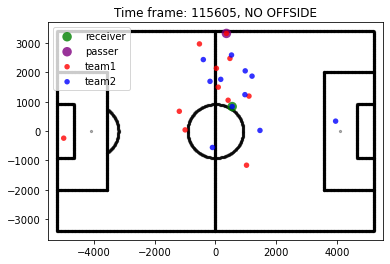

In [44]:
plot_offside(random.randint(0, len(df_final)-1))

# 7. Classification Models

Two different classification models will be evaluated: **Random Forest** and **Support Vector Classifier**. For the RF model, we will vary the number of decision trees (1, 10, 100, 1.000 and 10.000). For the SVC model, much more computer demanding, we will vary the size of the training set (25%, 50% and, hopefully, 75%).
At the end, we will compare their performances.

## 7.1 Random Forest Classification

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc


We need two sets of data, the features and the labels. A training set with 75% of the data will be used to generate the model.

In [6]:
import pandas as pd
import numpy as np
df_final = pd.read_csv('df_final.csv')
labels = df_final['offside']
features = df_final.drop('offside',axis=1)
feature_list = list(features.columns)
features = np.array(features)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

Five different Random Forest models will be generated, with 1, 10, 100, 1.000 and 10.000 trees. We will evaluate the performance using ROC, Error, Accuracy and Confusion Matrix.

In [ ]:
roc_auc=[]
accuracy=[]
errors=[]
confusion=[]
for i in range(5):
    print('Number of trees: ',10**i)
    print('Classify data')
    rfc=RandomForestClassifier(n_estimators=10**i,random_state=0)
    rfc.fit(train_features,train_labels)
    pred_labels=rfc.predict(test_features)
    
    print('Measure results')
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels, pred_labels)
    roc_auc.append(auc(false_positive_rate, true_positive_rate))
    
    accuracy.append(metrics.accuracy_score(test_labels,pred_labels))
    errors.append(abs(pred_labels - test_labels)/len(test_labels))
    confusion.append(metrics.confusion_matrix(test_labels,pred_labels))


Number of trees:  1
Classify data
Measure results
Number of trees:  10
Classify data
Measure results
Number of trees:  100
Classify data
Measure results
Number of trees:  1000
Classify data
Measure results
Number of trees:  10000
Classify data


In [ ]:
print('ok')